# K-means clustering on wholesale customers data

## Introduction

In this project we will be performing k-means clustering on wholesale customers data.

Dataset can be found at: https://www.kaggle.com/datasets/binovi/wholesale-customers-data-set/data

The dataset refers to clients of a wholesale distributor. It includes the annual spending in monetary units (m.u.) on six product categories: milk products, grocery products, frozen products, detergents and paper products, delicatessen products.

Our goal will be to identify different groups of customers based on their spending trends.

GitHub repository for this project can be found at: https://github.com/nabilahforuni/wholesale_data

## Loading and exploring data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [2]:
data = pd.read_csv('wholesale_customers_data.csv')
data.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Channel           440 non-null    int64
 1   Region            440 non-null    int64
 2   Fresh             440 non-null    int64
 3   Milk              440 non-null    int64
 4   Grocery           440 non-null    int64
 5   Frozen            440 non-null    int64
 6   Detergents_Paper  440 non-null    int64
 7   Delicassen        440 non-null    int64
dtypes: int64(8)
memory usage: 27.6 KB


We are dealing with a dream dataset: homogenous data with only numeric integer features and no missing values. No data cleaning will be necessary apart from getting rid of irrelevant columns and outliers.

Let's take a closer look at the statictical properties of our data.

In [4]:
data.describe()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,1.322727,2.543182,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,0.468052,0.774272,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,1.000000,1.000000,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,1.000000,2.000000,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,1.000000,3.000000,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,2.000000,3.000000,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,2.000000,3.000000,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


Columns 'Channel' and 'Region' contain no data about spending habits of our customers. We will delete them, but before that let's see distribution of those columns just out of curiosity.

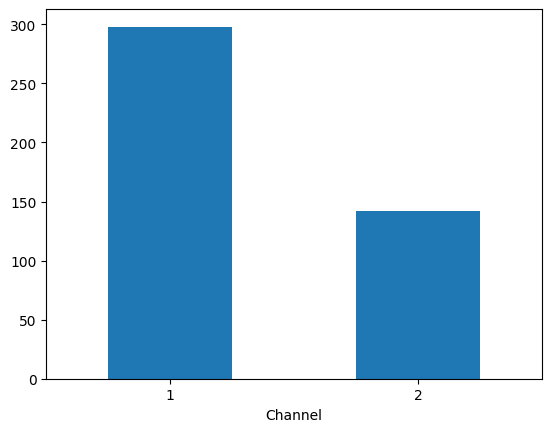

In [5]:
data.Channel.value_counts().plot.bar(rot=0);

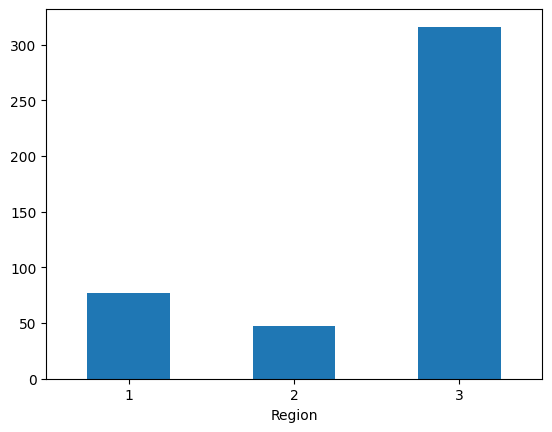

In [6]:
data.Region.value_counts().sort_index().plot.bar(rot=0);

In [7]:
data = data.drop(columns=['Channel', 'Region'])

## Data preprocessing

Now let's take a closer look at distributions in relevant columns.

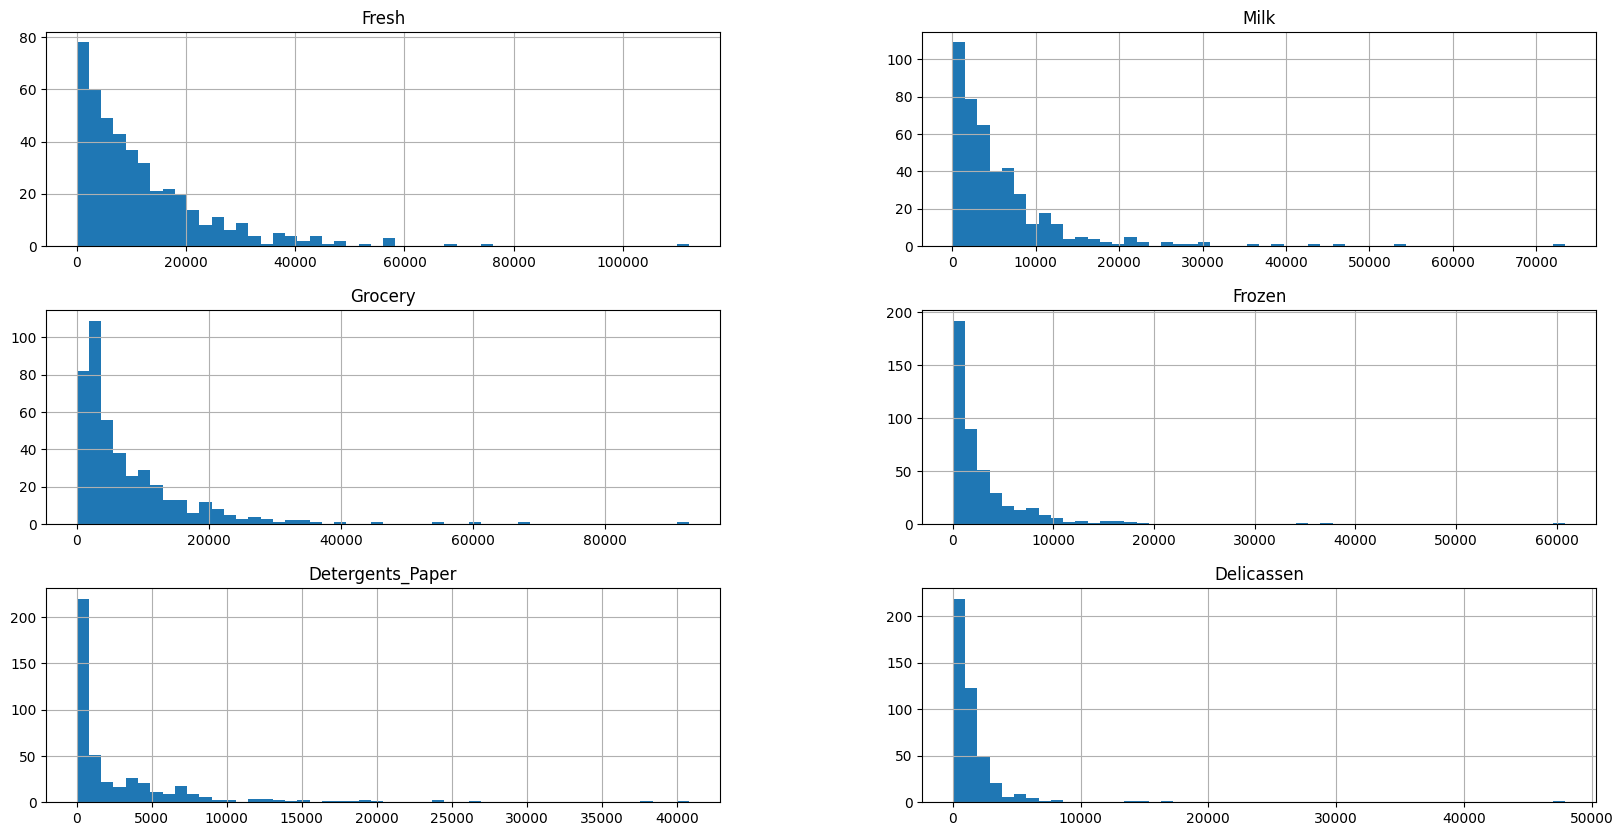

In [8]:
data.hist(bins=50, figsize=(20, 10));

In all columns data is skewed to the left. Let's put that data on a logarithmic scale.

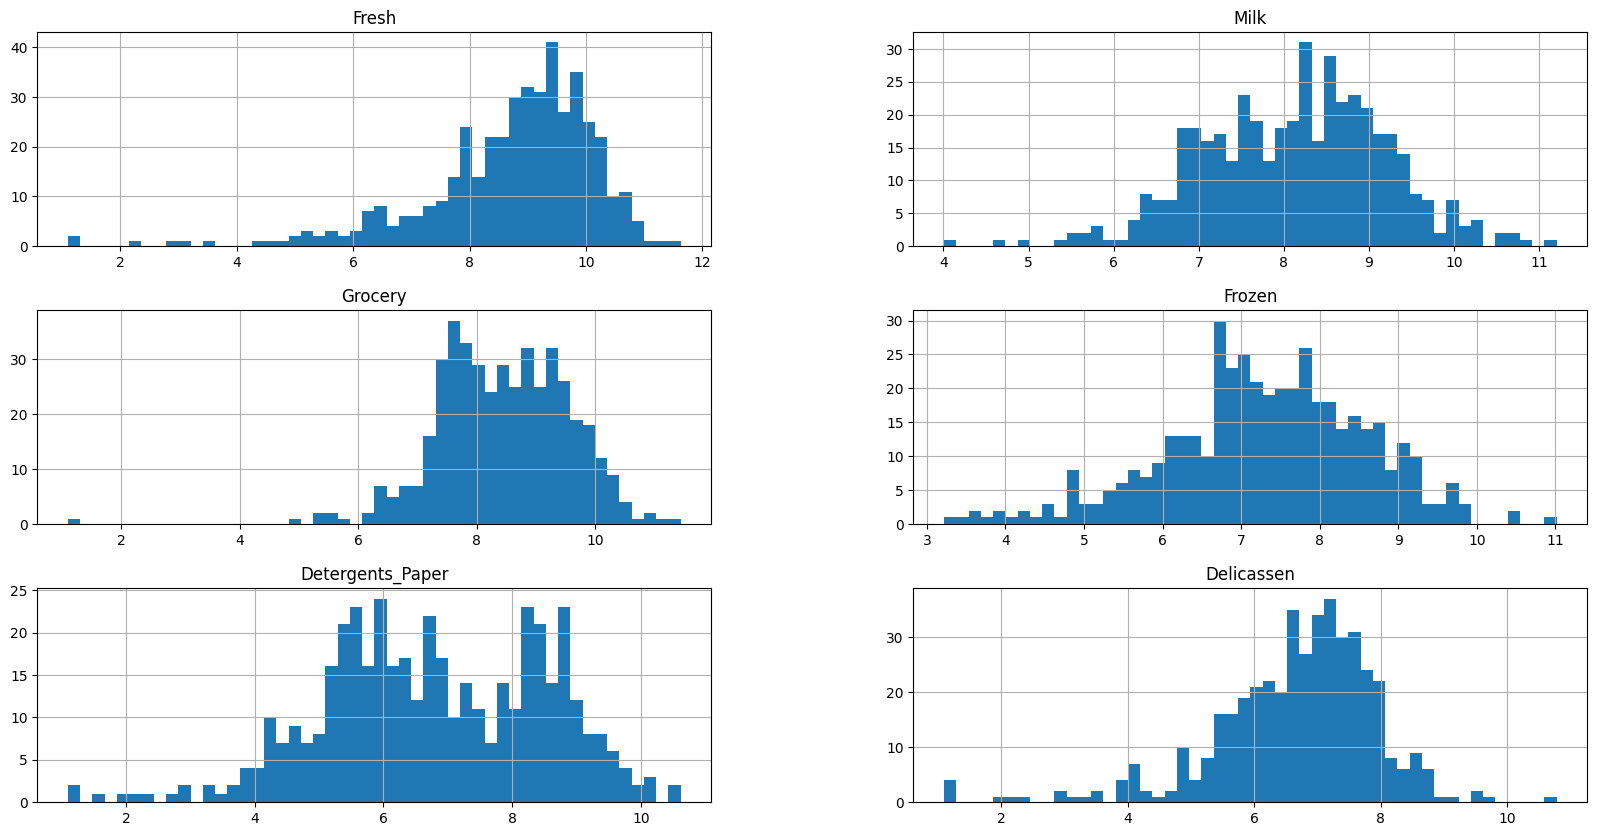

In [9]:
data = data.apply(np.log)
data.hist(bins=50, figsize=(20, 10));

That looks a lot closer to a normal distribution. Let's detect and get rid of outliers.

398


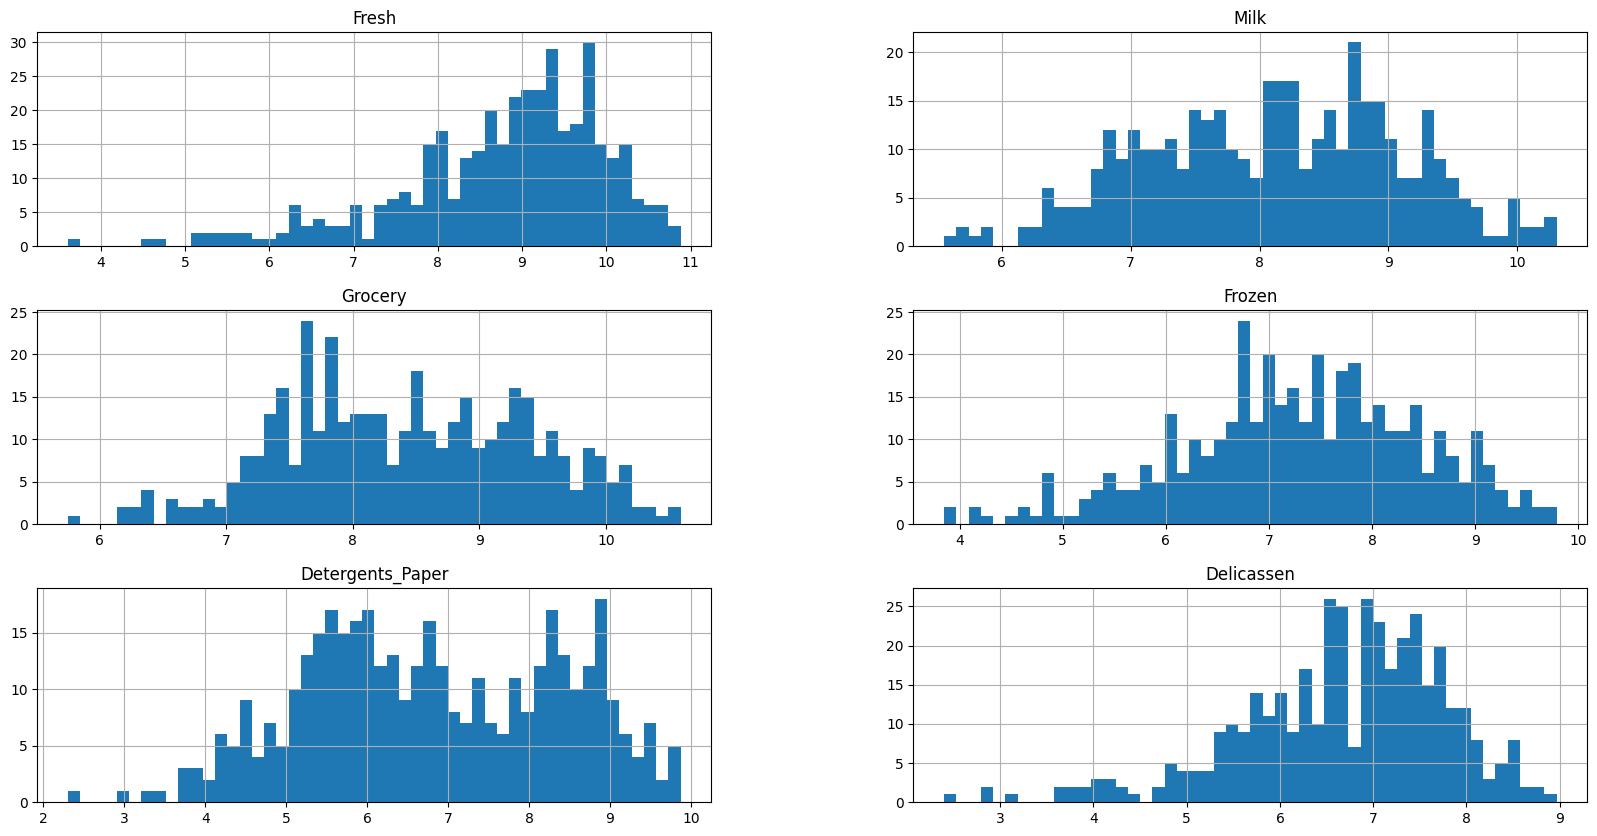

In [10]:
filtered = np.empty(shape=data.shape)

for i, column in enumerate(data.columns):
    q_low = data[column].quantile(0.01)
    q_hi  = data[column].quantile(0.99)
    filtered[:, i] = (q_low < data[column]) & (data[column] < q_hi)

data = data[filtered.all(axis=1)]
print(data.shape[0])
data.hist(bins=50, figsize=(20, 10));

Before performing k-means clustering we will be doing dimensionality reduction using PCA. Mean subtraction is necessary for performing classical PCA, so we well do that using sklearn's Standard Scaler.

In [11]:
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

In [12]:
data = data.astype('float')
data.iloc[:, :] = data_scaled
data.head()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,0.542871,1.095581,0.522395,-1.668350,0.687212,0.472053
1,0.067019,1.111808,0.766395,0.152889,0.820070,0.728871
2,-0.018446,1.001315,0.539120,0.421640,0.861878,2.075941
3,0.580256,-1.046340,-0.081780,1.267693,-0.373756,0.734978
4,1.014102,0.501460,0.471402,0.842575,0.426472,1.700511


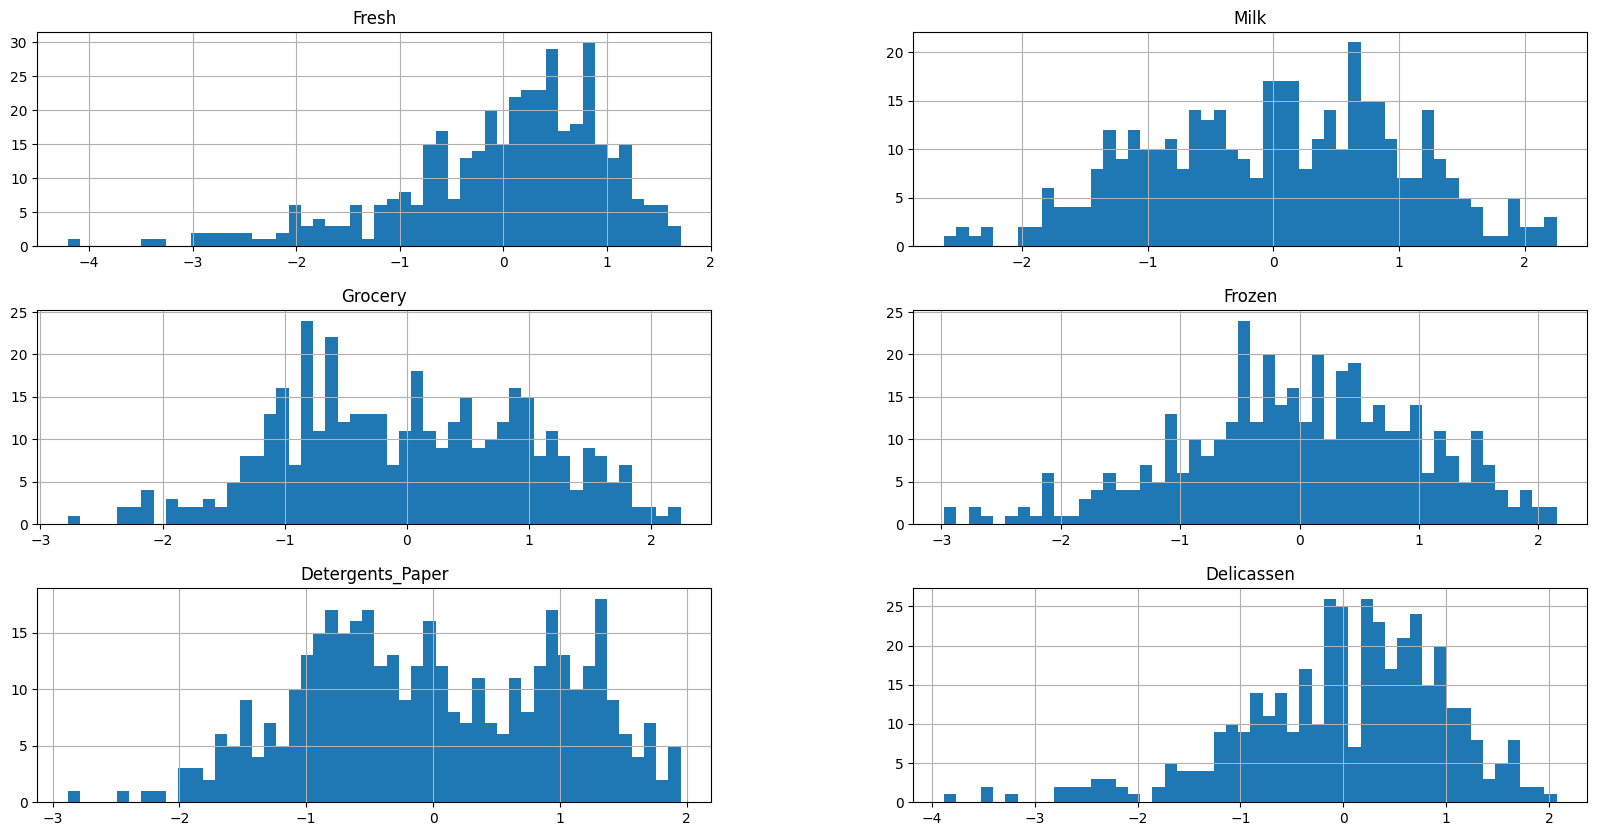

In [13]:
data.hist(bins=50, figsize=(20, 10));

## Dimensionality reduction with PCA

In [14]:
pca = PCA()
data_pca = pca.fit_transform(data)

In [15]:
pca.explained_variance_ratio_.cumsum()

array([0.4539667 , 0.70516391, 0.81716457, 0.92312498, 0.97196825,
       1.        ])

We'll  settle on 2 components since this choice will make later analysis much easier while retaining 70% of variance.

In [16]:
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data)

## Choice of number of clusters for K-means clustering

We will perform k-means clustering with different number of clusters and compare the results based on inertia.

In [17]:
results = {}

for i in range(2, 21):
    kmeans = KMeans(init="k-means++", n_clusters=i, n_init=4, random_state=0)
    kmeans.fit(data_pca)
    results[i] = {'inertia': kmeans.inertia_}

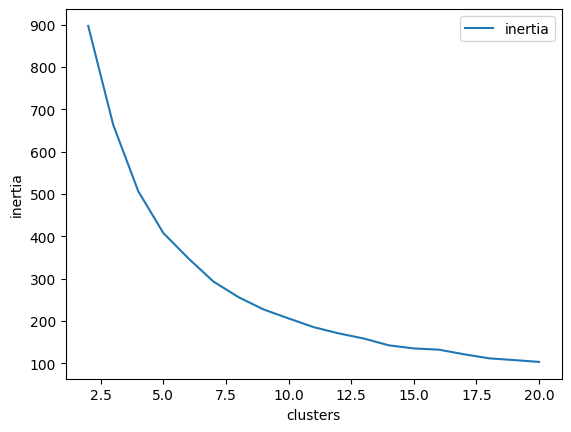

In [18]:
results_df = pd.DataFrame(results).transpose()
results_df.plot(xlabel='clusters', ylabel='inertia');

## Final clustering and visualizing the results

Number of clusters equal to 8 seems to give reasonable results, so we will use it as our final choice.

In [19]:
kmeans = KMeans(init="k-means++", n_clusters=8, n_init=4, random_state=0)
kmeans.fit(data_pca)

KMeans(n_init=4, random_state=0)

Finally, let's visualize the results of clustering.

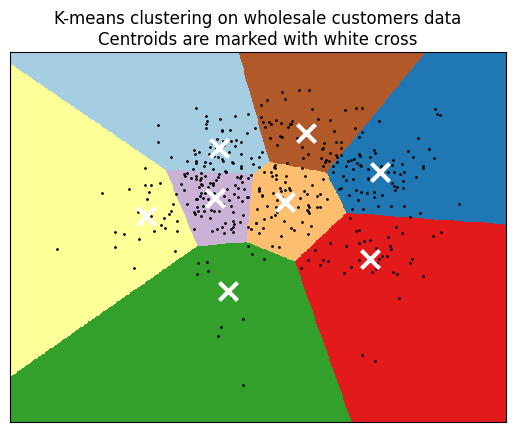

In [20]:
h = 0.02 

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = data_pca[:, 0].min() - 1, data_pca[:, 0].max() + 1
y_min, y_max = data_pca[:, 1].min() - 1, data_pca[:, 1].max() + 1   
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(
    Z,
    interpolation="nearest",
    extent=(xx.min(), xx.max(), yy.min(), yy.max()),
    cmap=plt.cm.Paired,
    aspect="auto",
    origin="lower",
)

plt.plot(data_pca[:, 0], data_pca[:, 1], "k.", markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(
    centroids[:, 0],
    centroids[:, 1],
    marker="x",
    s=169,
    linewidths=3,
    color="w",
    zorder=10,
)
plt.title(
    "K-means clustering on wholesale customers data\n"
    "Centroids are marked with white cross"
)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

## Conclusion

Performing clustering can help identify groups of customers with similar spending habits and thus, most likely, similar needs. This information can help better cater to those needs and increase customer satisfaction.

## References

[1] https://en.wikipedia.org/wiki/Principal_component_analysis

[2] https://scikit-learn.org/dev/auto_examples/cluster/plot_kmeans_digits.html#sphx-glr-auto-examples-cluster-plot-kmeans-digits-py

[3] https://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_iris.html